In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import skorch
import torch
from skorch import NeuralNetClassifier
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from scipy.stats import entropy
import random
import h5py
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import FeatureAgglomeration

In [2]:
from scifAI.dl.utils import train_validation_test_split
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.utils import get_statistics

In [3]:
from scifAI.dl.models import PretrainedModel
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

In [4]:


# Compare Algorithms
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [5]:
from sklearn.random_projection import GaussianRandomProjection

In [6]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


def classification_complete_report(y_true, y_pred ,labels = None  ): 
    print(classification_report(y_true, y_pred, labels = labels))
    print(15*"----")
    print("matthews correlation coeff: %.4f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.4f & balanced Accuracy: %.4f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.4f & micro F1 score: %.4f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.4f & micro Precision score: %.4f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.4f & micro Recall score: %.4f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    cm = confusion_matrix(y_true, y_pred,labels= labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    print(15*"----")

In [7]:
metadata = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/metadata_subset.csv.gz")
metadata["file"] = metadata.file.str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
metadata.set.unique()

array(['unlabeled', 'labeled', 'train', 'test', 'validation'],
      dtype=object)

In [9]:
indx = metadata.condition.isin(["-SEA","+SEA"])
metadata = metadata.loc[indx, :].reset_index(drop = True )

In [10]:
set_of_interesting_classes = ['B_cell',  
                              'T_cell', 
                              'T_cell_with_signaling',
                              'T_cell_with_B_cell_fragments',
                              'B_T_cell_in_one_layer',
                              'Synapses_without_signaling', 
                              'Synapses_with_signaling',
                              'No_cell_cell_interaction',
                              'Multiplets']

In [11]:
metadata["set"].unique()

array(['unlabeled', 'labeled', 'train', 'test', 'validation'],
      dtype=object)

In [12]:
unlabeled_index = metadata["set"] == "unlabeled"
unlabeled_index = unlabeled_index[unlabeled_index].index

 
labeled_index = metadata["label"].isin(set_of_interesting_classes)

train_index = metadata["set"] == "train"
train_index = train_index & labeled_index
train_index = train_index[train_index].index

validation_index = metadata["set"] == "validation"
validation_index = validation_index & labeled_index
validation_index = validation_index[validation_index].index

test_index = metadata["set"] == "test"
test_index = test_index & labeled_index
test_index = test_index[test_index].index

In [13]:


label_map = dict()
for i, cl in enumerate(set_of_interesting_classes):
    label_map[cl] = i

label_map['-1'] = -1
label_map[-1] = -1

print("Number of labeled images",labeled_index.sum())

Number of labeled images 5221


In [14]:
label_map

{'B_cell': 0,
 'T_cell': 1,
 'T_cell_with_signaling': 2,
 'T_cell_with_B_cell_fragments': 3,
 'B_T_cell_in_one_layer': 4,
 'Synapses_without_signaling': 5,
 'Synapses_with_signaling': 6,
 'No_cell_cell_interaction': 7,
 'Multiplets': 8,
 '-1': -1,
 -1: -1}

In [15]:
channels = {
     "Ch1": ("Greys", "BF"),  
     "Ch2": ("Greens", "Antibody"),
     "Ch3": ("Reds", "CD18"),
     "Ch4": ("Oranges", "F-Actin"),
     "Ch6": ("RdPu", "MHCII"),
     "Ch7": ("Purples", "CD3/CD4"),
     "Ch11": ("Blues", "P-CD3zeta"),
     "Ch12": ("Greens", "Live-Dead")
 }

In [16]:
reshape_size = 160
selected_channels = [0,3,4,5,6]

stats = dict()

stats["lower_bound"] = torch.tensor([756.5198,52.5891,45.7574,54.1436,39.0545])
stats["upper_bound"] = torch.tensor([835.3564,288.1139,271.3861,234.2525,90.0396])

In [17]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [18]:
class MinMaxScaler(object):
    def __init__(self, min_in , max_in, min_out, max_out):
        self.min_in = min_in.reshape(-1,1,1)
        self.max_in = max_in.reshape(-1,1,1)
        self.min_out = min_out
        self.max_out = max_out
        
    def __call__(self, tensor):
        
        tensor_ = (tensor - self.min_in)/(self.max_in - self.min_in)
        tensor_ = tensor_*(self.max_out - self.min_out) + self.min_out
        tensor_[tensor_<self.min_out]= self.min_out
        tensor_[tensor_>self.max_out]= self.max_out
        return tensor_
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_out={0}, max_out={1})'.format(self.min_out, self.max_out)

In [19]:
import torch.nn as nn
from torchvision.models import resnet152, resnet18, resnet34, resnet50
import torch.nn.functional as F

class ResNet34Modified(nn.Module):
    def __init__(self,  num_channels=3, num_classes=3, pretrained=True, progress=True, **kwargs):
        super().__init__()
        model = resnet34(pretrained=pretrained)
        if num_channels != 3:
            model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=(7, 7),
                                    stride=(2, 2), padding=(3, 3), bias=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        self.model = model

    def forward(self, x):                
        return self.model(x)

In [20]:
resnet34_modified = ResNet34Modified(len(selected_channels),
                                     len(set_of_interesting_classes), 
                                     pretrained = True)

/home/shetabs1/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/shetabs1/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
train_transform = transforms.Compose([ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.RandomResizedCrop(reshape_size, scale=(0.6, 1.0), ratio=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AddGaussianNoise(mean=0., std=0.05),
])



train_dataset = DatasetGenerator(metadata.loc[train_index.tolist(),:], 
                                 reshape_size=reshape_size, 
                                 scaling_factor = 1.,
                                label_map=label_map, 
                                 transform = train_transform,
                                selected_channels=selected_channels)

In [22]:
label_map

{'B_cell': 0,
 'T_cell': 1,
 'T_cell_with_signaling': 2,
 'T_cell_with_B_cell_fragments': 3,
 'B_T_cell_in_one_layer': 4,
 'Synapses_without_signaling': 5,
 'Synapses_with_signaling': 6,
 'No_cell_cell_interaction': 7,
 'Multiplets': 8,
 '-1': -1,
 -1: -1}

tensor(6)


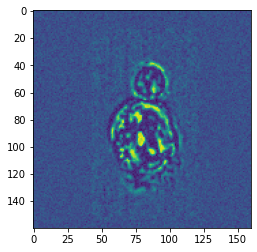

In [23]:
i = 40
plt.imshow(train_dataset[i][0][0,:,:])
print(train_dataset[i][1])

In [24]:
validation_transforms =  transforms.Compose([ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AddGaussianNoise(mean=0., std=0.01),
])

test_transforms =  transforms.Compose([ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
])

validation_dataset = DatasetGenerator(metadata.loc[validation_index.tolist(),:],
                                 reshape_size=reshape_size, 
                                label_map=label_map,
                                 scaling_factor = 1.,
                                transform=validation_transforms, 
                                selected_channels=selected_channels)

test_dataset = DatasetGenerator(metadata.loc[test_index.tolist(),:],
                                 reshape_size=reshape_size, 
                                label_map=label_map,
                                 scaling_factor = 1.,
                                transform=test_transforms, 
                                selected_channels=selected_channels)

In [25]:
lr_scheduler = LRScheduler(policy='ReduceLROnPlateau', factor=0.1, patience=10)

epoch_scoring = EpochScoring("f1_macro", 
                             name =  "valid_f1_macro", 
                             on_train = False,
                             lower_is_better = False)

early_stopping = EarlyStopping(monitor='valid_f1_macro', 
                               patience=50, 
                               threshold=0.0001, 
                               threshold_mode='rel', 
                               lower_is_better=False)

model = NeuralNetClassifier(    
    resnet34_modified, 
    criterion=nn.CrossEntropyLoss,
    lr=0.01,
    batch_size=32,
    max_epochs=1000,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    iterator_train__num_workers=5,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=1,
    callbacks=[lr_scheduler,epoch_scoring, early_stopping],
    train_split=predefined_split(validation_dataset),
    device="cuda",
    warm_start=True)

In [26]:
model = model.fit(train_dataset, y = None)

/home/shetabs1/.local/lib/python3.7/site-packages/skorch/net.py:1921: UserWarning: You set iterator_valid__shuffle=True; this is most likely not what you want because the values returned by predict and predict_proba will be shuffled.
  UserWarning)


  epoch    train_loss    valid_acc    valid_f1_macro    valid_loss      dur
-------  ------------  -----------  ----------------  ------------  -------
      1        2.0031       0.3529            0.2264        1.7289  32.3147
      2        1.3122       0.5677            0.5079        1.1056  6.1975
      3        1.3616       0.5171            0.4260        1.4660  6.1728
      4        1.0726       0.5363            0.4831        1.2830  6.2872
      5        0.8878       0.5062            0.4273        1.4148  6.1250
      6        0.8561       0.6443            0.5925        0.8441  6.0854
      7        0.7544       0.6553            0.6157        0.8752  6.2975
      8        0.7432       0.7100            0.6811        0.7027  6.2112
      9        0.6812       0.7237            0.7219        0.6762  6.1987
     10        0.6371       0.6443            0.6210        0.8941  6.1824
     11        0.5945       0.7045            0.6993        0.7875  6.2152
     12        0.5813 

In [27]:
#model.module.load_state_dict(torch.load('resnet_18_imagenet_pretraiend_supervised_learning.pth')) 


In [28]:
## START from here

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        89
           1       0.94      0.97      0.95        94
           2       0.93      0.93      0.93        70
           3       0.88      0.97      0.92        88
           4       0.90      0.77      0.83        74
           5       0.77      0.78      0.78        69
           6       0.90      0.87      0.89        94
           7       0.86      0.93      0.89        82
           8       0.98      0.90      0.94        71

    accuracy                           0.91       731
   macro avg       0.91      0.90      0.90       731
weighted avg       0.91      0.91      0.91       731

------------------------------------------------------------
matthews correlation coeff: 0.8938
Cohen Kappa score: 0.8936
Accuracy: 0.9056 & balanced Accuracy: 0.9005
macro F1 score: 0.9016 & micro F1 score: 0.9056
macro Precision score: 0.9051 & micro Precision score: 0.9056
macro Recall score

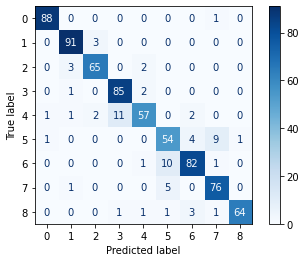

------------------------------------------------------------


In [29]:
preds = model.predict(validation_dataset)

classification_complete_report([label_map[t] for t in validation_dataset.metadata.label], 
                               preds  )

In [30]:
set_of_interesting_classes

['B_cell',
 'T_cell',
 'T_cell_with_signaling',
 'T_cell_with_B_cell_fragments',
 'B_T_cell_in_one_layer',
 'Synapses_without_signaling',
 'Synapses_with_signaling',
 'No_cell_cell_interaction',
 'Multiplets']

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       190
           1       0.95      0.93      0.94       200
           2       0.90      0.90      0.90       148
           3       0.91      0.92      0.91       189
           4       0.85      0.88      0.86       161
           5       0.85      0.86      0.86       147
           6       0.89      0.93      0.91       196
           7       0.97      0.95      0.96       182
           8       0.96      0.88      0.92       154

    accuracy                           0.92      1567
   macro avg       0.92      0.92      0.92      1567
weighted avg       0.92      0.92      0.92      1567

------------------------------------------------------------
matthews correlation coeff: 0.9095
Cohen Kappa score: 0.9094
Accuracy: 0.9196 & balanced Accuracy: 0.9161
macro F1 score: 0.9168 & micro F1 score: 0.9196
macro Precision score: 0.9183 & micro Precision score: 0.9196
macro Recall score

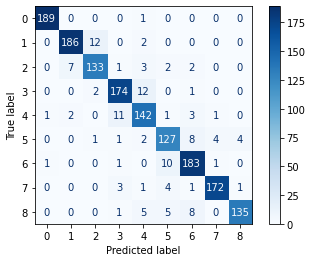

------------------------------------------------------------


In [31]:
preds = model.predict(test_dataset)

classification_complete_report([label_map[t] for t in test_dataset.metadata.label],  preds   )

In [32]:
model.module

ResNet34Modified(
  (model): ResNet(
    (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [148]:
from captum.attr import LRP

In [149]:
lrp = LRP(model.module_)

In [ ]:
{'B_cell': 0,
 'T_cell': 1,
 'T_cell_with_signaling': 2,
 'T_cell_with_B_cell_fragments': 3,
 'B_T_cell_in_one_layer': 4,
 'Synapses_without_signaling': 5,
 'Synapses_with_signaling': 6,
 'No_cell_cell_interaction': 7,
 'Multiplets': 8,
 '-1': -1,
 -1: -1}

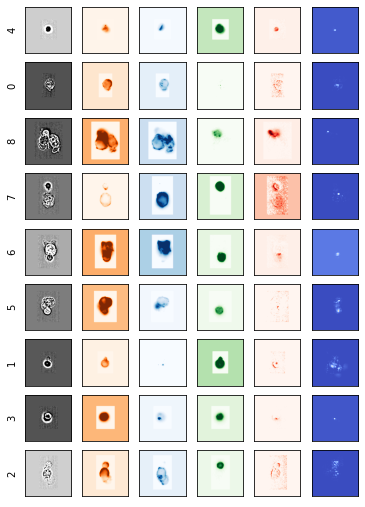

In [167]:
cmaps_dict = {
    0: "Greys",
    1: "Oranges",
    2: "Blues",
    3: "Greens",
    4: "Reds"
}


samples = metadata.loc[test_index,:].reset_index(drop=True).groupby('label').apply(lambda x: x.sample(1)).index.tolist()
samples = [s[1] for s in samples]
n_samples = len(samples)
ncols = 6
fig, ax = plt.subplots(ncols=ncols, nrows=n_samples, figsize=(ncols,n_samples))

for i, s in enumerate(samples):
    input_ = test_dataset[s]
    ax[i,0].set_ylabel(int(input_[1])) 
    input_ = input_[0]
    input_ = torch.unsqueeze(input_, dim= 0)
    # Attribution size matches input size: 3x3x32x32
    attribution = lrp.attribute(input_.to("cuda"), target=6) 
    
    for j in range(5):
        ax[i,j].imshow(input_[0,j,:,:], cmap=cmaps_dict[j])
        
    ax[i,-1].imshow(attribution.max(1)[0][0].detach().cpu().numpy(), cmap="coolwarm")
    
for i  in range(n_samples):
    for j in range(ncols):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])


plt.savefig('Supplementary Figure - samples vs ResNet34 LRP.png', bbox_inches="tight")
plt.savefig('Supplementary Figure - samples vs ResNet34 LRP.svg', bbox_inches="tight")